# Clustering Exploration

In this notebook I'm going to see if clustering makes any sense for us in this project and see if our uses have any natural clusterings.  

In [29]:
# imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import calinski_harabasz_score, adjusted_rand_score
from sklearn.decomposition import PCA

parent_dir = '../../../'

In [2]:
# plot params:
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 25
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.facecolor'] = 'white' # or EAEAF2

In [3]:
df = pd.read_csv(parent_dir + 'data/joined_dfs_lc')
df.head()

,movieId,userId,rating,title,genres,imdbId,tmdbId
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0
1,1,5,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0
2,1,7,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0
3,1,15,2.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0
4,1,17,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 7 columns):
movieId    100836 non-null int64
userId     100836 non-null int64
rating     100836 non-null float64
title      100816 non-null object
genres     100816 non-null object
imdbId     100836 non-null int64
tmdbId     100823 non-null float64
dtypes: float64(2), int64(3), object(2)
memory usage: 5.4+ MB


In [5]:
len(df.userId.unique())

610

For clustering to work, all columns need to be numerical.  

Since `movieId` is attached to `title` we can probably just drop the title column.  `imdbId` and `tmdbId` columns are also just identification columns and so we can drop those as well.  

`genres` probably contain useful information and so we might start by just one hot encoding those variables even though there's a lot of them and 'double up' info... when we perform PCA, it will probably 0-out the double up genres...

Keeping `userId` should hopefully keep the same users in the same cluster...

### Drop columns:

In [6]:
to_drop = ['title', 'imdbId', 'tmdbId']
df_dropped = df.drop(to_drop, axis = 1)
df_dropped.head()

,movieId,userId,rating,genres
0,1,1,4.0,Adventure|Animation|Children|Comedy|Fantasy
1,1,5,4.0,Adventure|Animation|Children|Comedy|Fantasy
2,1,7,4.5,Adventure|Animation|Children|Comedy|Fantasy
3,1,15,2.5,Adventure|Animation|Children|Comedy|Fantasy
4,1,17,4.5,Adventure|Animation|Children|Comedy|Fantasy


### Dummy out genres

In [7]:
len(df_dropped.genres.unique())

952

In [9]:
ohe = OneHotEncoder(sparse = False, handle_unknown = "ignore")

In [10]:
ohe.fit(df_dropped[['genres']])

ValueError: Input contains NaN

In [11]:
df_dropped['genres'].isna().sum()

20

In [12]:
df_dropped[df_dropped['genres'].isna()]

,movieId,userId,rating,genres
69625,6003,111,4.0,NaN
69626,6003,156,3.5,NaN
69627,6003,182,3.0,NaN
69628,6003,288,4.0,NaN
69629,6003,356,4.5,NaN
69630,6003,387,3.5,NaN
69631,6003,414,3.5,NaN
69632,6003,474,3.5,NaN
69633,6003,480,3.5,NaN
69634,6003,552,3.0,NaN


It's these 5 movies again that have no title or genre info.  Since it's only 20 rows and only 5 movies, we'll drop these since we still have quite a large dataset it shouldn't matter too much.  Also I don't even know if this clustering will be meaningful...

In [15]:
df_dropped.dropna(inplace = True)

In [16]:
ohe.fit(df_dropped[['genres']])

OneHotEncoder(categorical_features=None, categories=None, drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='ignore',
              n_values=None, sparse=False)

In [17]:
df_dropped.head()

,movieId,userId,rating,genres
0,1,1,4.0,Adventure|Animation|Children|Comedy|Fantasy
1,1,5,4.0,Adventure|Animation|Children|Comedy|Fantasy
2,1,7,4.5,Adventure|Animation|Children|Comedy|Fantasy
3,1,15,2.5,Adventure|Animation|Children|Comedy|Fantasy
4,1,17,4.5,Adventure|Animation|Children|Comedy|Fantasy


In [18]:
print(ohe.categories_[0])

['(no genres listed)' 'Action' 'Action|Adventure'
 'Action|Adventure|Animation' 'Action|Adventure|Animation|Children'
 'Action|Adventure|Animation|Children|Comedy'
 'Action|Adventure|Animation|Children|Comedy|Fantasy'
 'Action|Adventure|Animation|Children|Comedy|IMAX'
 'Action|Adventure|Animation|Children|Comedy|Romance'
 'Action|Adventure|Animation|Children|Comedy|Sci-Fi'
 'Action|Adventure|Animation|Children|Comedy|Sci-Fi|IMAX'
 'Action|Adventure|Animation|Children|Comedy|Western'
 'Action|Adventure|Animation|Children|Fantasy'
 'Action|Adventure|Animation|Children|Fantasy|Sci-Fi'
 'Action|Adventure|Animation|Children|Sci-Fi'
 'Action|Adventure|Animation|Comedy'
 'Action|Adventure|Animation|Comedy|Crime|Mystery'
 'Action|Adventure|Animation|Comedy|Fantasy|Mystery|Sci-Fi'
 'Action|Adventure|Animation|Comedy|Fantasy|Sci-Fi'
 'Action|Adventure|Animation|Comedy|Sci-Fi'
 'Action|Adventure|Animation|Comedy|Thriller'
 'Action|Adventure|Animation|Crime|Fantasy'
 'Action|Adventure|Animation|Dr

In [19]:
# make df with encoded genres
df_encoded = pd.DataFrame(ohe.transform(df_dropped[['genres']]), index = df_dropped.index)

In [22]:
# combine with original df with 'genre' dropped
cluster_df = pd.concat([df_dropped.drop('genres', axis = 1), df_encoded], axis = 1)

In [23]:
cluster_df.head()

,movieId,userId,rating,0,1,2,3,4,5,6,...,941,942,943,944,945,946,947,948,949,950
0,1,1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,7,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,15,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,17,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Prepare for Clustering

In [26]:
# scale
ss = StandardScaler()
ss_df = ss.fit_transform(cluster_df)

In [27]:
# create kmeans:
ss_kmeans = KMeans(n_clusters = 4, random_state = 15)
ss_kmeans.fit(ss_df)
ss_preds = ss_kmeans.predict(ss_df)

In [35]:
pca = PCA(n_components = 8)
pca_df = pca.fit_transform(ss_df)

In [34]:
np.cumsum(pca.explained_variance_ratio_)

array([0.00154803, 0.00274193, 0.00379727, 0.00484954, 0.00590039,
       0.00695042, 0.00800014, 0.00904966])

In [36]:
k_means_3 = KMeans(n_clusters=3).fit(pca_df)
k_means_4 = KMeans(n_clusters=4).fit(pca_df)
k_means_5 = KMeans(n_clusters=5).fit(pca_df)
k_means_6 = KMeans(n_clusters=6).fit(pca_df)
k_means_7 = KMeans(n_clusters=7).fit(pca_df)
k_means_8 = KMeans(n_clusters=8).fit(pca_df)

k_list = [k_means_3, k_means_4, k_means_5, k_means_6, k_means_7, k_means_8]

In [37]:
CH_score = []

for model in k_list:
    labels = model.labels_
    CH_score.append(calinski_harabasz_score(pca_df, labels))

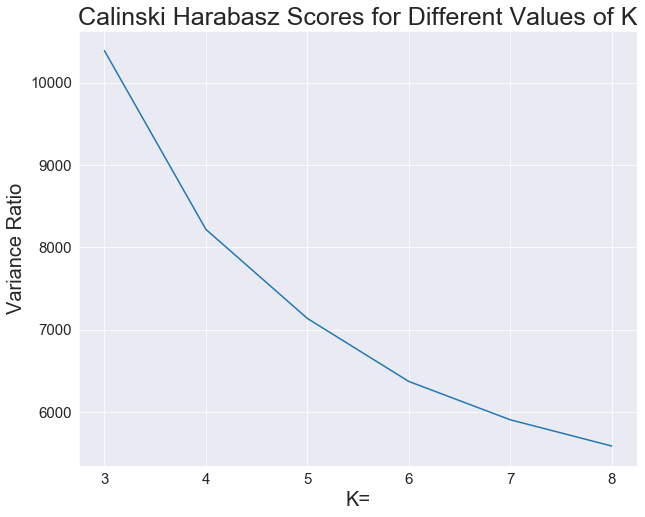

In [39]:
plt.subplots(figsize = (10, 8))
plt.plot([3, 4, 5, 6, 7, 8], CH_score)
plt.xticks([3,4,5,6,7, 8])
plt.title('Calinski Harabasz Scores for Different Values of K')
plt.ylabel('Variance Ratio')
plt.xlabel('K=')
plt.show();

In [40]:
wcss_score = []

for model in k_list:
    labels = model.labels_
    wcss_score.append(model.inertia_)

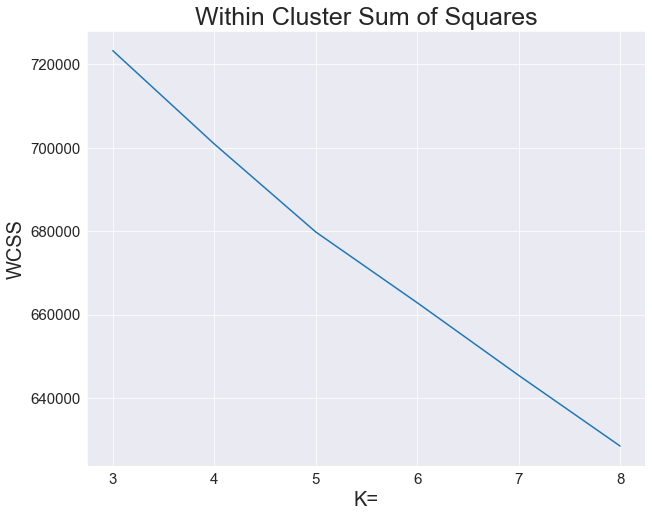

In [41]:
plt.subplots(figsize = (10, 8))
plt.plot([3, 4, 5, 6, 7, 8], wcss_score)
plt.xticks([3,4,5,6,7, 8])
plt.title('Within Cluster Sum of Squares')
plt.ylabel('WCSS')
plt.xlabel('K=')
plt.show();

I don't think this is very meaningful... 

It looks like our data has 4 clusters... what this really means though in movie recommendations... I don't really know... 